In [57]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mxnet as mx
from mxnet import gluon
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset
from gluonts.mx import SimpleFeedForwardEstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation import Evaluator

%matplotlib inline

# data

In [4]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers']


## m4_hourly

In [5]:
dataset = get_dataset("m4_hourly")

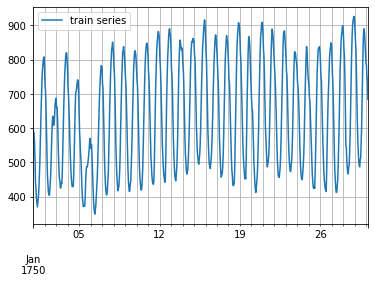

In [6]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which = "both")
plt.legend(["train series"], loc = "upper left")
plt.show()

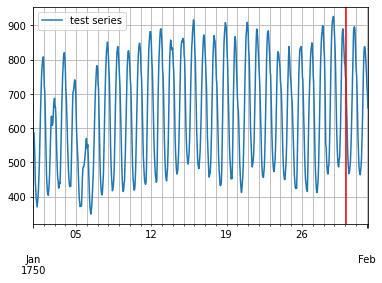

In [18]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], c = "red")
plt.grid(which = "both")
plt.legend(["test series"], loc = "upper left")
plt.show()

In [20]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


# 自定义数据

In [39]:
N = 10
T = 100
prediction_length = 24
freq = "H"
custom_dataset = np.random.normal(size = (N, T))
start = pd.Period("01-01-2019", freq = freq)
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([
    {
        "target": x, 
        "start": start
    } for x in custom_dataset[:, :-prediction_length]
], freq = freq)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([
    {
        "target": x,
        "start": start,
    } for x in custom_dataset
], freq = freq)

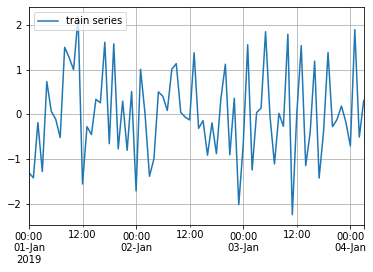

In [40]:
entry = next(iter(train_ds))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which = "both")
plt.legend(["train series"], loc = "upper left")
plt.show()

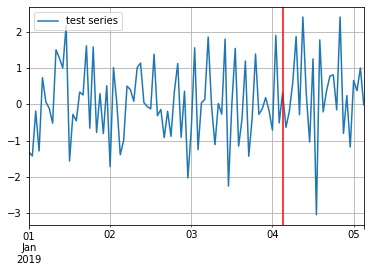

In [41]:
entry = next(iter(test_ds))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], c = "red")
plt.grid(which = "both")
plt.legend(["test series"], loc = "upper left")
plt.show()

# Model

In [44]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions = [10],
    prediction_length = dataset.metadata.prediction_length,
    context_length = 100,
    trainer = Trainer(ctx = "cpu", epochs = 5, learning_rate = 1e-3, num_batches_per_epoch = 100),
)
perdictor = estimator.train(dataset.train)

100%|█████████████████| 100/100 [00:00<00:00, 121.91it/s, epoch=5/5, avg_epoch_loss=4.8]


In [52]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset = dataset.test,
    predictor = perdictor,
    num_samples = 100,
)
forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
np.array(ts_entry[:5]).reshape(-1)

array([605., 586., 586., 559., 511.], dtype=float32)

In [53]:
dataset_test_entry = next(iter(dataset.test))
dataset_test_entry["target"][:5]
forecast_entry = forecasts[0]

In [54]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00
Frequency of the time series: <Hour>
Mean of the future window:
 [676.6499  584.2258  647.4009  415.5912  506.78027 500.6509  461.2026
 524.36536 498.0692  584.4525  592.01416 702.4052  771.74506 811.66565
 798.01227 893.14667 914.2277  846.1372  846.0243  886.8667  819.9387
 744.88116 825.58167 684.1482  605.6393  557.0634  611.823   473.7215
 491.77234 558.47186 429.67758 418.00214 493.8453  500.12375 618.3916
 638.5097  801.4575  755.3618  756.3736  865.9504  792.4777  832.0725
 786.60315 837.6704  810.2369  788.9508  800.42505 767.2495 ]
0.5-quantile (median) of the future window:
 [674.5386  587.06665 630.7581  427.25052 492.9561  495.8417  470.24854
 524.2248  473.142   586.6105  601.2888  704.78534 755.72626 812.1318
 801.20337 904.7256  912.97235 845.52606 842.9116  883.95416 811.99023
 759.72736 832.8564  682.7501  619.8266  576.68945 611.43524 488.05197
 485.45822 5

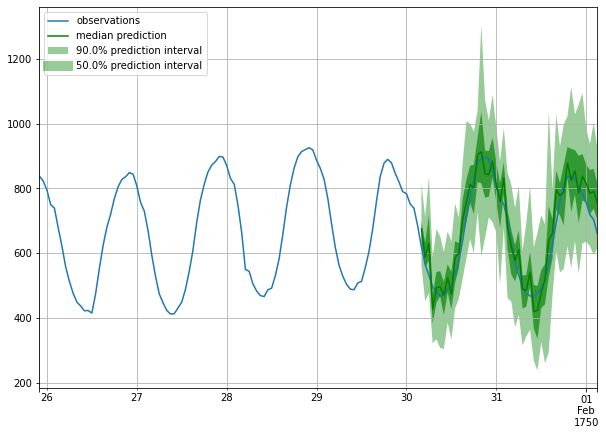

In [55]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
    
plot_prob_forecasts(ts_entry, forecast_entry)

In [58]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)
print(json.dumps(agg_metrics, indent=4))
item_metrics.head()

Running evaluation: 414it [00:00, 3927.93it/s]


{
    "MSE": 9699766.19888718,
    "abs_error": 9723551.180046082,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 4.082146856550188,
    "MAPE": 0.2699498832825685,
    "sMAPE": 0.19416280358357896,
    "MSIS": 66.47208414597134,
    "QuantileLoss[0.1]": 5673738.780522919,
    "Coverage[0.1]": 0.10532407407407406,
    "QuantileLoss[0.5]": 9723551.03351736,
    "Coverage[0.5]": 0.521286231884058,
    "QuantileLoss[0.9]": 7261246.807457444,
    "Coverage[0.9]": 0.8897443639291465,
    "RMSE": 3114.4447657467263,
    "NRMSE": 0.4251905026901091,
    "ND": 0.06680150517520374,
    "wQuantileLoss[0.1]": 0.0389789988751887,
    "wQuantileLoss[0.5]": 0.06680150416854075,
    "wQuantileLoss[0.9]": 0.04988529470407964,
    "mean_absolute_QuantileLoss": 7552845.540499241,
    "mean_wQuantileLoss": 0.051888599249269696,
    "MAE_Coverage": 0.012288647342995196,
    "OWA": NaN
}


,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0,1750-01-30 04:00,2624.175293,1909.613525,31644.0,659.250000,42.371302,0.938928,0.063197,0.061410,0.060347,14.009730,1106.157367,0.000000,1909.613495,0.666667,1518.552484,1.000000
1,1,1750-01-30 04:00,175078.500000,16979.785156,124149.0,2586.437500,165.107988,2.142510,0.144186,0.130881,0.136769,14.233055,4653.709546,0.166667,16979.784180,0.937500,8693.345605,1.000000
2,2,1750-01-30 04:00,38176.531250,7325.964844,65030.0,1354.791667,78.889053,1.934670,0.102791,0.110047,0.112655,14.284275,3587.207507,0.000000,7325.964600,0.250000,3128.006372,0.729167
3,3,1750-01-30 04:00,302110.604167,20978.748047,235783.0,4912.145833,258.982249,1.687595,0.086844,0.087240,0.088975,14.768060,11680.264746,0.062500,20978.748047,0.416667,8083.568848,0.937500
4,4,1750-01-30 04:00,80618.604167,10187.184570,131088.0,2731.000000,200.494083,1.058550,0.079906,0.076565,0.077713,14.007197,5102.453125,0.041667,10187.184204,0.750000,7286.593994,1.000000


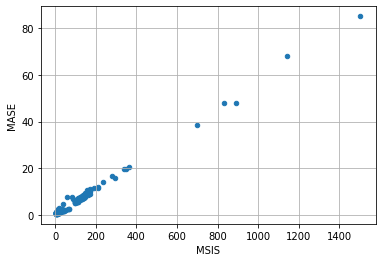

In [59]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()